# Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
import importlib
import helper.series

In [4]:
importlib.reload(helper.series)

<module 'helper.series' from '/home/jupyter/multitarget_training/helper/series.py'>

In [5]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
matplotlib 3.0.3
numpy 1.18.1
pandas 0.25.3
sklearn 0.19.2
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [6]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Dataset Builder

In [39]:
def timeseries_dataset(series, window_size, shift, batchsize, targetsize, kernel_effect=0):
    """
    From the original timeseries it generates the inputs for the network, and the labels.
    The labels lenght will be the target lenght of the forecast.
    Parameters:
      series: the input time series
      window_size: the lenght of the input
      shift: window shift along the series
      batchsize: batchsize
      targetsize: the size of the forecasted length
      kernel_effect: conv kernels can shorten the sequence, this parameter determines their effect
    Output: dataset of the input and label batches
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    stype = ds.element_spec.dtype
    ds = ds.window(window_size + targetsize, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + targetsize))
    if targetsize > 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], tf.map_fn(lambda i: window[i+1+kernel_effect:i+1+kernel_effect+targetsize], tf.range(window_size-kernel_effect), dtype=stype)))
    elif targetsize == 1:
        ds = ds.map(lambda window: (window[:-targetsize, np.newaxis], window[targetsize+kernel_effect:, np.newaxis]))
    elif targetsize == 0:
        ds = ds.map(lambda window: (window[:, np.newaxis], window[:, np.newaxis]))          
    return ds.batch(batchsize, drop_remainder=True)

# Build Time Series

In [26]:
time = np.arange(8 * 365)
builder = helper.series.SeriesBuilder(baseline=10, slope=0.05, period=365, amplitude=50, noise_level=2)
t_series = builder.generate_series(time)

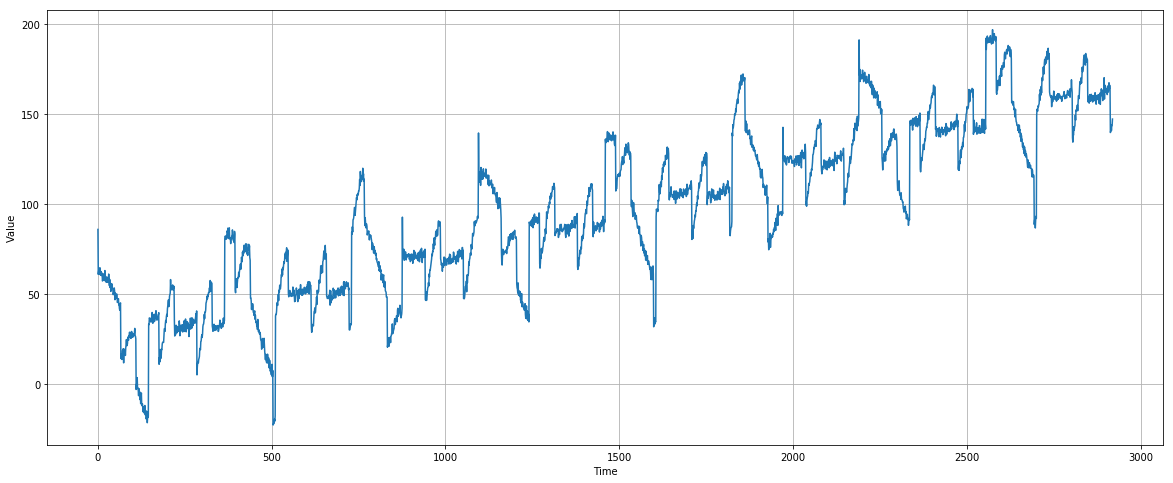

In [27]:
plt.figure(figsize=(20,8))
helper.series.plot_series(time, t_series)

In [41]:
# check output of the function
ds_demo = timeseries_dataset(time, window_size=3, shift=1, batchsize=2, targetsize=2, kernel_effect=1)
next(iter(ds_demo))

(<tf.Tensor: shape=(2, 3, 1), dtype=int64, numpy=
 array([[[0],
         [1],
         [2]],
 
        [[1],
         [2],
         [3]]])>, <tf.Tensor: shape=(2, 2, 2), dtype=int64, numpy=
 array([[[2, 3],
         [3, 4]],
 
        [[3, 4],
         [4, 5]]])>)

In [29]:
# split the time and timeseries to train and validation set
time_train = time[:365*6]
x_train = t_series[:365*6]
time_valid = time[365*6:365*7]
x_valid = t_series[365*6:365*7]
time_test = time[365*7:]
x_test = t_series[365*7:]

In [42]:
# build the training / validation dataset for the 1 and more target size
train_set_1 = timeseries_dataset(x_train, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4) # kernel_effect of the simple_conv_and_lstm_layout
valid_set_1 = timeseries_dataset(x_valid, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4)
test_set_1 = timeseries_dataset(x_test, window_size=60, shift=1, batchsize=16, targetsize=1, kernel_effect=4)

train_set_10 = timeseries_dataset(x_train, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)
valid_set_10 = timeseries_dataset(x_valid, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)
test_set_10 = timeseries_dataset(x_test, window_size=60, shift=1, batchsize=16, targetsize=10, kernel_effect=4)

# Network Layouts and Trainers

In [43]:
def simple_conv_and_lstm_layout(batchsize, window_size, targetsize):    
    """
    Define a simple LSTM layout
    """    
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

    model = keras.models.Sequential([
        keras.layers.Conv1D(filters=20, kernel_size=5, strides=1, padding="valid",
                            batch_input_shape=[batchsize, window_size, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(targetsize)),
        keras.layers.Lambda(lambda x: x * 200.0) # scale the outputs for faster learning
    ])
    return model

In [44]:
def simple_lstm_layout(batchsize, targetsize):  
    """
    Define a simple LSTM layout
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    # model layout
    model = keras.models.Sequential([
    keras.layers.LSTM(20, 
                      return_sequences=True,
                      batch_input_shape=[batchsize, None, 1]),
    keras.layers.LSTM(20, 
                      return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(targetsize)),
    keras.layers.Lambda(lambda x: x * 200.0) # scale the outputs for faster learning
    ])
    return model

In [45]:
def learning_rate_finder(model, train_set):  
    """
    Goes trough learning rates and gives back the history object
    to find optimal learning rate.
    """
    # check learning rates to find the best
    lr_schedule = keras.callbacks.LearningRateScheduler(
      lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    # get history to find the best learning rate
    return model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [46]:
def model_trainer(model, lr, train_set, valid_set, checkpoint_name):
    """
    Builds simple lstm network.
    Returns the history object
    """
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9) # use best learning rate estimation
    model.compile(loss=keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])
    model_checkpoint = keras.callbacks.ModelCheckpoint(
      checkpoint_name, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=50)
    return model.fit(train_set, epochs=5,
            validation_data=valid_set,
            callbacks=[early_stopping, model_checkpoint])

# Test LSTM with target size 1

In [47]:
model_lstm_ts1 = simple_lstm_layout(batchsize=16, targetsize=1)

In [48]:
model_lstm_ts1 = simple_conv_and_lstm_layout(batchsize=16, window_size = 60, targetsize=1)

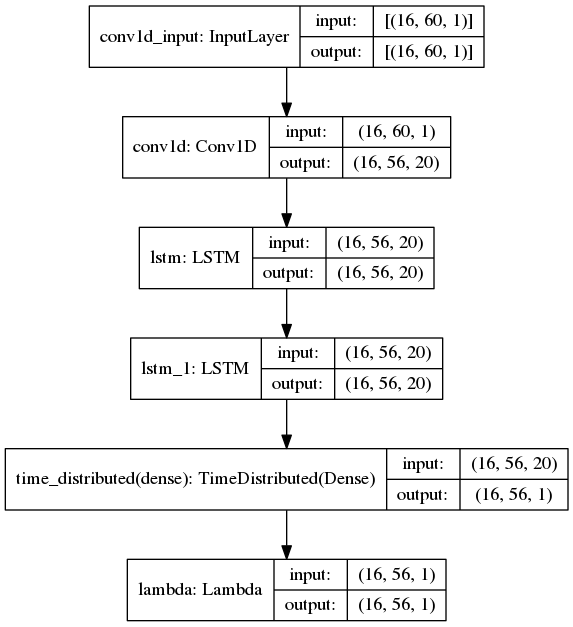

In [49]:
keras.utils.plot_model(model_lstm_ts1, "model.png", show_shapes=True)

In [50]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts1, train_set=train_set_1), 1e-8, 1e-4, 0, 30)

Epoch 1/100
133/133 [==============================] - 16s 117ms/step - loss: 31.4194 - mae: 31.9156
Epoch 2/100
133/133 [==============================] - 12s 87ms/step - loss: 30.3390 - mae: 30.8346
Epoch 3/100
133/133 [==============================] - 11s 86ms/step - loss: 28.6875 - mae: 29.1834
Epoch 4/100
133/133 [==============================] - 12s 89ms/step - loss: 27.2583 - mae: 27.7536
Epoch 5/100
133/133 [==============================] - 12s 89ms/step - loss: 26.2706 - mae: 26.7662
Epoch 6/100
129/133 [============================>.] - ETA: 0s - loss: 25.4245 - mae: 25.9196

KeyboardInterrupt: 

In [25]:
# we see that lr around 4e-7 can be good, so train the network with that
model_lstm_ts1 = simple_lstm_layout(batchsize=16, targetsize=1)
history_lstm_1 = model_trainer(model_lstm_ts1, lr = 5e-7, train_set = train_set_1, valid_set = valid_set_1, checkpoint_name = "cp_lstm_1.h5")

Epoch 1/5
133/133 [==============================] - 7s 56ms/step - loss: 28.4866 - mae: 28.9817 - val_loss: 26.7659 - val_mae: 27.2629
Epoch 2/5
133/133 [==============================] - 3s 23ms/step - loss: 28.1559 - mae: 28.6507 - val_loss: 26.1184 - val_mae: 26.6150
Epoch 3/5
133/133 [==============================] - 3s 23ms/step - loss: 21.9453 - mae: 22.4362 - val_loss: 25.2897 - val_mae: 25.7880
Epoch 4/5
133/133 [==============================] - 3s 23ms/step - loss: 19.2986 - mae: 19.7905 - val_loss: 24.6457 - val_mae: 25.1423
Epoch 5/5
133/133 [==============================] - 3s 23ms/step - loss: 17.7826 - mae: 18.2754 - val_loss: 23.9531 - val_mae: 24.4498


In [34]:
model_lstm_ts1 = keras.models.load_model("cp_lstm_1.h5")

(304, 60, 1)
(304,)


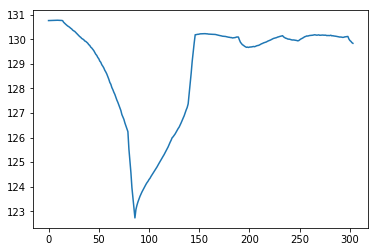

In [26]:
rnn_forecast = model_lstm_ts1.predict(test_set_1)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

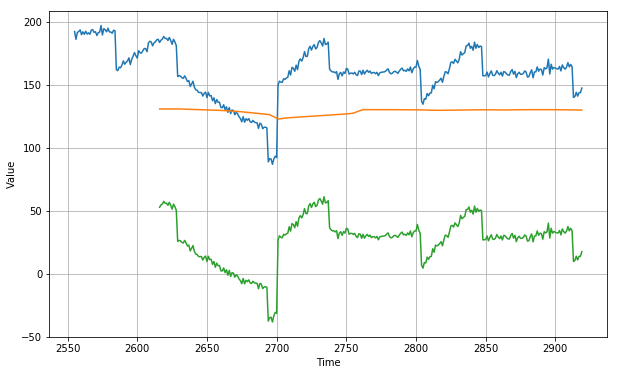

In [27]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[61:], rnn_forecast)
helper.series.plot_series(time_test[61:], x_test[61:] - rnn_forecast)

In [30]:
keras.metrics.mean_absolute_error(x_test[61:], rnn_forecast).numpy()

29.336664

# Test LSTM with target size 5

In [28]:
model_lstm_ts10 = simple_lstm_layout(batchsize=16, targetsize=10)

Epoch 1/100
134/134 [==============================] - 6s 45ms/step - loss: 81.5498 - mae: 82.0490
Epoch 2/100
134/134 [==============================] - 4s 27ms/step - loss: 80.8565 - mae: 81.3557
Epoch 3/100
134/134 [==============================] - 4s 28ms/step - loss: 80.1649 - mae: 80.6641
Epoch 4/100
134/134 [==============================] - 4s 29ms/step - loss: 79.4633 - mae: 79.9626
Epoch 5/100
134/134 [==============================] - 4s 31ms/step - loss: 78.7378 - mae: 79.2370
Epoch 6/100
134/134 [==============================] - 4s 31ms/step - loss: 77.9757 - mae: 78.4749
Epoch 7/100
134/134 [==============================] - 4s 28ms/step - loss: 77.1657 - mae: 77.6649
Epoch 8/100
134/134 [==============================] - 4s 27ms/step - loss: 76.2964 - mae: 76.7957
Epoch 9/100
134/134 [==============================] - 4s 28ms/step - loss: 75.3580 - mae: 75.8572
Epoch 10/100
134/134 [==============================] - 4s 27ms/step - loss: 74.3410 - mae: 74.8402
Epoch 11/

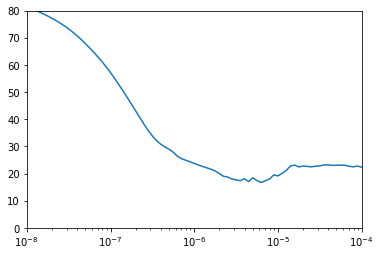

In [29]:
helper.series.lr_loss_chart(learning_rate_finder(model_lstm_ts10, train_set=train_set_10), 1e-8, 1e-4, 0, 80)

In [16]:
# we see that lr around 2e-6 can be good, so train the network with that
%%time
model_lstm_ts10 = simple_lstm_layout(batchsize=16, targetsize=10)
history_lstm_10 = model_trainer(model_lstm_ts10, lr = 2e-6, train_set = train_set_10, valid_set = valid_set_10, checkpoint_name = "cp_lstm_10.h5")

Epoch 1/2000
134/134 [==============================] - 12s 89ms/step - loss: 52.9419 - mae: 53.4403 - val_loss: 77.2411 - val_mae: 77.7407
Epoch 2/2000
134/134 [==============================] - 4s 31ms/step - loss: 30.9694 - mae: 31.4667 - val_loss: 50.5105 - val_mae: 51.0096
Epoch 3/2000
134/134 [==============================] - 4s 31ms/step - loss: 29.3150 - mae: 29.8112 - val_loss: 44.3474 - val_mae: 44.8462
Epoch 4/2000
134/134 [==============================] - 4s 32ms/step - loss: 27.6455 - mae: 28.1413 - val_loss: 41.3436 - val_mae: 41.8423
Epoch 5/2000
134/134 [==============================] - 4s 31ms/step - loss: 25.1316 - mae: 25.6266 - val_loss: 37.9926 - val_mae: 38.4911
Epoch 6/2000
134/134 [==============================] - 4s 32ms/step - loss: 24.0471 - mae: 24.5419 - val_loss: 35.7633 - val_mae: 36.2619
Epoch 7/2000
134/134 [==============================] - 4s 31ms/step - loss: 23.1587 - mae: 23.6532 - val_loss: 34.2485 - val_mae: 34.7465
Epoch 8/2000
134/134 [====

In [17]:
model_lstm_ts10 = keras.models.load_model("cp_lstm_10.h5")

(320, 30, 5)
(320,)


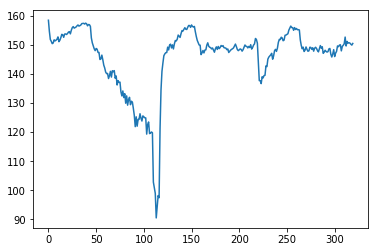

In [18]:
rnn_forecast = model_lstm_ts10.predict(test_set_10)
print(rnn_forecast.shape)
# in every step we only need the last output of the "return sequence"
rnn_forecast = np.squeeze(rnn_forecast[:, -1, 0])
print(rnn_forecast.shape)

plt.plot(rnn_forecast)

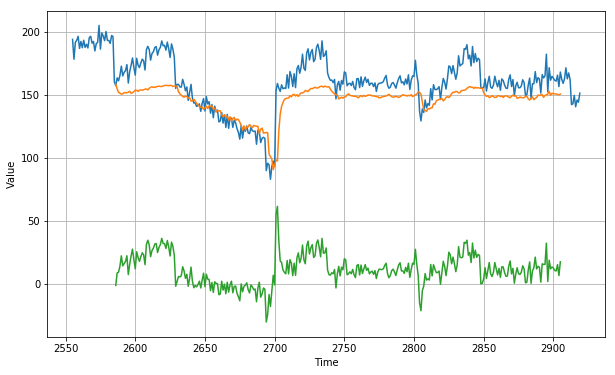

In [19]:
plt.figure(figsize=(10, 6))
helper.series.plot_series(time_test, x_test)
helper.series.plot_series(time_test[61:-14], rnn_forecast)
helper.series.plot_series(time_test[61:-14], x_test[61:-14] - rnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_test[61:-14], rnn_forecast).numpy()

13.490346